In [1]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

In [2]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None):
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx
        
        self._idx_to_token = {
            idx: token for token, idx in self._token_to_idx.items()
        }
    
    def to_serializable(self):
        return {
            'token_to_idx': self._token_to_idx
        }
    
    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)
    
    def add_token(self, token):
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        return [self.add_token(token) for token in tokens]
    
    def lookup_token(self, token):
        return self._token_to_idx[token]
    
    def lookup_index(self, index):
        if index not in self._idx_to_token:
            raise KeyError('the index (%d) is not in the Vocabulary' % index)
        return self._idx_to_token[index]
    
    def __str__(self):
        return "<Vocabulary(size=%d)>" %len(self)
    
    def __len__(self):
        return len(self._token_to_idx)

In [3]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                mask_token="<MASK>", begin_seq_token="<BEGIN>",
                end_seq_token="<END>"):
        super(SequenceVocabulary, self).__init__(token_to_idx)
        
        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token
        
        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)
        
    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({
            'unk_token': self._unk_token,
            'mask_token': self._mask_token,
            'begin_seq_token': self._begin_seq_token,
            'end_seq_token': self._end_seq_token
        })
        
    def lookup_token(self, token):
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [4]:
class NMTVectorizer(object):
    def __init__(self, source_vocab, target_vocab, max_source_length, max_target_length):
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab
        
        self.max_source_length = max_source_length
        self.max_target_length = max_target_length
        
    def _vectorize(self, indices, vector_length=-1, mask_index=0):
        if vector_length < 0:
            vector_length = len(indices)
        
        vector = np.zeros(vector_length, dtype=np.int64)
        vector[:len(indices)] = indices
        vector[len(indices):] = mask_index
        
        return vector
    
    def _get_source_indices(self, text):
        indices = [self.source_vocab.begin_seq_index]
        indices.extend(self.source_vocab.lookup_token(token) for token in text.split(" "))
        indices.append(self.source_vocab.end_seq_index)
        return indices
    
    def _get_target_indices(self, text):
        indices = [self.target_vocab.lookup_token(token) for token in text.split(" ")]
        x_indices = [self.target_vocab.begin_seq_index] + indices
        y_indices = indices + [self.target_vocab.end_seq_index]
        return x_indices, y_indices
    
    def vectorize(self, source_text, target_text, use_dataset_max_lengths=True):
        source_vector_length = -1
        target_vector_length = -1
        
        if use_dataset_max_lengths:
            source_vector_length = self.max_source_length + 2
            target_vector_length = self.max_target_length + 1
            
            source_indices = self._get_source_indices(source_text)
            source_vector = self._vectorize(source_indices,
                                           vector_length=source_vector_length,
                                           mask_index=self.source_vocab.mask_index)
            target_x_indices, target_y_indices = self._get_target_indices(target_text)
            target_x_vector = self._vectorize(target_x_indices,
                                             vector_length=target_vector_length,
                                             mask_index=self.target_vocab.mask_index)
            target_y_vector = self._vectorize(target_y_indices,
                                             vector_length=target_vector_length,
                                             mask_index=self.target_vocab.mask_index)
            return {
                'source_vector': source_vector,
                'target_x_vector': target_x_vector,
                'target_y_vector': target_y_vector,
                'source_length': len(source_indices)
            }
        
    @classmethod
    def from_dataframe(cls, bitext_df):
        source_vocab = SequenceVocabulary()
        target_vocab = SequenceVocabulary()
        
        max_source_length = 0
        max_target_length = 0
        
        for _, row in bitext_df.iterrows():
            source_tokens = row['source_language'].split(" ")
            if len(source_tokens) > max_source_length:
                max_source_length = len(source_tokens)
            for token in source_tokens:
                source_vocab.add_token(token)
                
            target_tokens = row['target_language'].split(" ")
            if len(target_tokens) > max_target_length:
                max_target_length = len(target_tokens)
            for token in target_tokens:
                target_vocab.add_token(token)
        
        return cls(source_vocab, target_vocab, max_source_length, max_target_length)
    
    @classmethod
    def from_serializable(cls, contents):
        source_vocab = SequenceVocabulary.from_serializable(contents['source_vocab'])
        target_vocab = SequenceVocabulary.from_serializable(contents['target_vocab'])
        
        return cls(source_vocab=source_vocab,
                  target_vocab=target_vocab,
                  max_source_length=contents['max_source_length'],
                  max_ta_vectorizerget_length=contents['max_target_length'])
    
    def to_serializable(self):
        return {
            'source_vocab': self.source_vocab.to_serializable(),
            'target_vocab': self.target_vocab.to_serializable(),
            'max_source_lenght': self.max_source_length,
            'max_target_lenght': self.max_target_length
        }

In [5]:
class NMTDataset(Dataset):
    def __init__(self, text_df, vectorizer):
        self.text_df = text_df
        self._vectorizer = vectorizer
        
        self.train_df = self.text_df[self.text_df.split=='train']
        self.train_size = len(self.train_df)
        
        self.val_df = self.text_df[self.text_df.split=='val']
        self.val_size = len(self.val_df)
        
        self.test_df = self.text_df[self.text_df.split=='test']
        self.test_size = len(self.test_df)
        
        self._lookup_dict = {
            'train': (self.train_df, self.train_size),
            'val': (self.val_df, self.val_size),
            'test': (self.test_df, self.test_size)
        }
        
        self.set_split('train')
    
    @classmethod
    def load_dataset_and_make_vectorizer(cls, dataset_csv):
        text_df = pd.read_csv(dataset_csv)
        train_subset = text_df[text_df.split=='train']
        return cls(text_df, NMTVectorizer.from_dataframe(train_subset))
    
    @classmethod
    def load_dataset__and_load_vectorizer(cls, dataset_csv, vectorizer_filepath):
        text_df = pd.read_csv(dataset_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(text_df, vectorizer)
    
    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return NMTVectorizer.from_serializable(json.load(fp))
        
    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, 'w') as fp:
            json.dump(self._vectorizer.to_serializable(), fp)
    
    def get_vectorizer(self):
        return self._vectorizer
    
    def set_split(self, split='train'):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]
        
    def __len__(self):
        return self._target_size
    
    def __getitem__(self, index):
        row = self._target_df.iloc[index]
        
        vector_dict = self._vectorizer.vectorize(row.source_language, row.target_language)
        
        return {
            'x_source': vector_dict['source_vector'],
            'x_target': vector_dict['target_x_vector'],
            'y_target': vector_dict['target_y_vector'],
            'x_source_length': vector_dict['source_length']
        }
    
    def get_num_batches(self, batch_size):
        return len(self) // batch_size

In [6]:
def generate_nmt_batches(dataset, batch_size, shuffle=True, drop_last=True, device='cpu'):
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                           shuffle=shuffle, drop_last=drop_last)
    
    for data_dict in dataloader:
        lengths = data_dict['x_source_length'].numpy()
        sorted_length_indices = lengths.argsort()[::-1].tolist()
        
        out_data_dict = {}
        for  name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name][sorted_length_indices].to(device)
        yield out_data_dict

In [7]:
class NMTEncoder(nn.Module):
    def __init__(self, num_embeddings, embedding_size, rnn_hidden_size):
        super(NMTEncoder, self).__init__()
    
        self.source_embedding = nn.Embedding(num_embeddings, embedding_size, padding_idx=0)
        self.birnn = nn.GRU(embedding_size, rnn_hidden_size, bidirectional=True, batch_first=True)
    
    def forward(self, x_source, x_lengths):
        x_embedded = self.source_embedding(x_source)
        x_packed = pack_padded_sequence(x_embedded, x_lengths.detach().cpu().numpy(), 
                                        batch_first=True)
        
        x_birnn_out, x_birnn_h  = self.birnn(x_packed)
        x_birnn_h = x_birnn_h.permute(1, 0, 2)
        
        x_birnn_h = x_birnn_h.contiguous().view(x_birnn_h.size(0), -1)
        
        x_unpacked, _ = pad_packed_sequence(x_birnn_out, batch_first=True)
        
        return x_unpacked, x_birnn_h

def verbose_attention(encoder_state_vectors, query_vector):
    batch_size, num_vectors, vector_size = encoder_state_vectors.size()
    vector_scores = torch.sum(encoder_state_vectors * query_vector.view(batch_size, 1, vector_size), 
                              dim=2)
    vector_probabilities = F.softmax(vector_scores, dim=1)
    weighted_vectors = encoder_state_vectors * vector_probabilities.view(batch_size, num_vectors, 1)
    context_vectors = torch.sum(weighted_vectors, dim=1)
    return context_vectors, vector_probabilities, vector_scores

def terse_attention(encoder_state_vectors, query_vector):
    vector_scores = torch.matmul(encoder_state_vectors, query_vector.unsqueeze(dim=2)).squeeze()
    vector_probabilities = F.softmax(vector_scores, dim=-1)
    context_vectors = torch.matmul(encoder_state_vectors.transpose(-2, -1), 
                                   vector_probabilities.unsqueeze(dim=2)).squeeze()
    return context_vectors, vector_probabilities


class NMTDecoder(nn.Module):
    def __init__(self, num_embeddings, embedding_size, rnn_hidden_size, bos_index):
        super(NMTDecoder, self).__init__()
        self._rnn_hidden_size = rnn_hidden_size
        self.target_embedding = nn.Embedding(num_embeddings=num_embeddings, 
                                             embedding_dim=embedding_size, 
                                             padding_idx=0)
        self.gru_cell = nn.GRUCell(embedding_size + rnn_hidden_size, 
                                   rnn_hidden_size)
        self.hidden_map = nn.Linear(rnn_hidden_size, rnn_hidden_size)
        self.classifier = nn.Linear(rnn_hidden_size * 2, num_embeddings)
        self.bos_index = bos_index
    
    def _init_indices(self, batch_size):
        return torch.ones(batch_size, dtype=torch.int64) * self.bos_index
    
    def _init_context_vectors(self, batch_size):
        return torch.zeros(batch_size, self._rnn_hidden_size)
            
    def forward(self, encoder_state, initial_hidden_state, target_sequence):
        target_sequence = target_sequence.permute(1, 0)
        output_sequence_size = target_sequence.size(0)

        h_t = self.hidden_map(initial_hidden_state)

        batch_size = encoder_state.size(0)
        context_vectors = self._init_context_vectors(batch_size)
        y_t_index = self._init_indices(batch_size)
        
        h_t = h_t.to(encoder_state.device)
        y_t_index = y_t_index.to(encoder_state.device)
        context_vectors = context_vectors.to(encoder_state.device)

        output_vectors = []
        self._cached_p_attn = []
        self._cached_ht = []
        self._cached_decoder_state = encoder_state.cpu().detach().numpy()
        
        for i in range(output_sequence_size):
            y_t_index = target_sequence[i]
                
            y_input_vector = self.target_embedding(y_t_index)
            rnn_input = torch.cat([y_input_vector, context_vectors], dim=1)
            
            h_t = self.gru_cell(rnn_input, h_t)
            self._cached_ht.append(h_t.cpu().detach().numpy())
            
            context_vectors, p_attn, _ = verbose_attention(encoder_state_vectors=encoder_state, 
                                                           query_vector=h_t)
            
            self._cached_p_attn.append(p_attn.cpu().detach().numpy())
            
            prediction_vector = torch.cat((context_vectors, h_t), dim=1)
            score_for_y_t_index = self.classifier(F.dropout(prediction_vector, 0.3))
            
            output_vectors.append(score_for_y_t_index)
            
        output_vectors = torch.stack(output_vectors).permute(1, 0, 2)
        
        return output_vectors
    
    
class NMTModel(nn.Module):
    def __init__(self, source_vocab_size, source_embedding_size, 
                 target_vocab_size, target_embedding_size, encoding_size, 
                 target_bos_index):
        super(NMTModel, self).__init__()
        self.encoder = NMTEncoder(num_embeddings=source_vocab_size, 
                                  embedding_size=source_embedding_size,
                                  rnn_hidden_size=encoding_size)
        decoding_size = encoding_size * 2
        self.decoder = NMTDecoder(num_embeddings=target_vocab_size, 
                                  embedding_size=target_embedding_size, 
                                  rnn_hidden_size=decoding_size,
                                  bos_index=target_bos_index)
    
    def forward(self, x_source, x_source_lengths, target_sequence):
        encoder_state, final_hidden_states = self.encoder(x_source, x_source_lengths)
        decoded_states = self.decoder(encoder_state=encoder_state, 
                                      initial_hidden_state=final_hidden_states, 
                                      target_sequence=target_sequence)
        return decoded_states

In [8]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
        
def make_train_state(args):
    return {
        'stop_early': False,
        'early_stopping_step': 0,
        'early_stopping_best_val': 1e8,
        'learning_rate': args.learning_rate,
        'epoch_index': 0,
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'test_loss': -1,
        'test_acc': -1,
        'model_filename': args.model_state_file
    }

def update_train_state(args, model, train_state):
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False
    
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
        
        if loss_t >= loss_tm1:
            train_state['early_stopping_step'] += 1
        else:
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t
            
            train_state['early_stopping_step'] = 0
            
        train_state['stop_early'] = train_state['early_stopping_step'] >= args.early_stopping_criteria
    
    return train_state

def normalize_sizes(y_pred, y_true):
    if len(y_pred.size()) == 3:
        y_pred = y_pred.contiguous().view(-1, y_pred.size(2))
    if len(y_true.size()) == 2:
        y_true = y_true.contiguous().view(-1)
    return y_pred, y_true

def compute_accuracy(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)
    
    _, y_pred_indices = y_pred.max(dim=1)
    
    correct_indices = torch.eq(y_pred_indices, y_true).float()
    valid_indices = torch.ne(y_true, mask_index).float()
    
    n_correct = (correct_indices * valid_indices).sum().item()
    n_valid = valid_indices.sum().item()
    
    return n_correct / n_valid * 100

def sequence_loss(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)
    return F.cross_entropy(y_pred, y_true, ignore_index=mask_index)

In [9]:
args = Namespace(
    dataset_csv='data/n/simplest_eng_fra.csv',
    vectorizer_file='vectorizer.json',
    model_state_file='model.pth',
    save_dir='model_storage/c/nmt_luong_no_sampling',
    reload_from_files=True,
    expand_filepaths_to_save_dir=True,
    cuda=False,
    seed=1337,
    learning_rate=5e-4,
    batch_size=64,
    num_epochs=100,
    early_stopping_criteria=5,
    source_embedding_size=64,
    target_embedding_size=64,
    encoding_size=64,
    catch_keyboard_interrupt=True
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                       args.vectorizer_file)
    args.model_state_file = os.path.join(args.save_dir, 
                                        args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))

if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device('cuda' if args.cuda else 'cpu')

print('Using CUDA: {}'.format(args.cuda))

set_seed_everywhere(args.seed, args.cuda)

handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/c/nmt_luong_no_sampling/vectorizer.json
	model_storage/c/nmt_luong_no_sampling/model.pth
Using CUDA: False


In [10]:
if args.reload_from_files and os.path.exists(args.vectorizer_file):
    dataset = NMTDataset.load_dataset_and_load_vectorizer(args.dataset_csv, args.vectorizer_file)
else:
    dataset = NMTDataset.load_dataset_and_make_vectorizer(args.dataset_csv)

vectorizer = dataset.get_vectorizer()

In [11]:
model = NMTModel(source_vocab_size=len(vectorizer.source_vocab),
                source_embedding_size=args.source_embedding_size,
                target_vocab_size=len(vectorizer.target_vocab),
                target_embedding_size=args.target_embedding_size,
                encoding_size=args.encoding_size,
                target_bos_index=vectorizer.target_vocab.begin_seq_index)

if args.reload_from_files and os.path.exists(args.model_state_file):
    model.load_state_dict(torch.load(args.model_state_file))
    print('Reloaded model')
else:
    print("New model")

Reloaded model


In [12]:
model = model.to(args.device)

optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
mask_index = vectorizer.target_vocab.mask_index
train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        dataset.set_split('train')
        batch_generator = generate_nmt_batches(dataset, 
                                               batch_size=args.batch_size, 
                                               device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        model.train()
        
        for batch_index, batch_dict in enumerate(batch_generator):
            optimizer.zero_grad()

            y_pred = model(batch_dict['x_source'], 
                           batch_dict['x_source_length'], 
                           batch_dict['x_target'])

            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            loss.backward()

            optimizer.step()
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        dataset.set_split('val')
        batch_generator = generate_nmt_batches(dataset, 
                                               batch_size=args.batch_size, 
                                               device=args.device)
        running_loss = 0.
        running_acc = 0.
        model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            y_pred = model(batch_dict['x_source'], 
                           batch_dict['x_source_length'], 
                           batch_dict['x_target'])

            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=model, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break
            
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.set_postfix(best_val=train_state['early_stopping_best_val'] )
        epoch_bar.update()
        
except KeyboardInterrupt:
    print("Exiting loop")

/home/malinroot/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


/home/malinroot/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/malinroot/.local/lib/python3.7/site-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Exiting loop


In [13]:
model.eval()

NMTModel(
  (encoder): NMTEncoder(
    (source_embedding): Embedding(3025, 64, padding_idx=0)
    (birnn): GRU(64, 64, batch_first=True, bidirectional=True)
  )
  (decoder): NMTDecoder(
    (target_embedding): Embedding(4911, 64, padding_idx=0)
    (gru_cell): GRUCell(192, 128)
    (hidden_map): Linear(in_features=128, out_features=128, bias=True)
    (classifier): Linear(in_features=256, out_features=4911, bias=True)
  )
)

In [15]:
from nltk.translate import bleu_score
import seaborn as sns
import matplotlib.pyplot as plt

chencherry = bleu_score.SmoothingFunction()

In [27]:
def sentence_from_indices(indices, vocab, strict=True, return_string=True):
    ignore_indices = set([vocab.mask_index, vocab.begin_seq_index, vocab.end_seq_index])
    out = []
    for index in indices:
        if index == vocab.begin_seq_index and strict:
            continue
        elif index == vocab.end_seq_index and strict:
            break
        else:
            out.append(vocab.lookup_index(index))
    if return_string:
        return " ".join(out)
    else:
        return out

class NMTSampler:
    def __init__(self, vectorizer, model):
        self.vectorizer = vectorizer
        self.model = model
        
    def apply_to_batch(self, batch_dict):
        self._last_batch = batch_dict
        y_pred = self.model(x_source=batch_dict['x_source'],
                           x_source_lengths=batch_dict['x_source_length'],
                           target_sequence=batch_dict['x_target'])
        self._last_batch['y_pred'] = y_pred
        
        attention_batched = np.stack(self.model.decoder._cached_p_attn).transpose(1, 0, 2)
        self._last_batch['attention'] = attention_batched
        
    def _get_source_sentence(self, index, return_string=True):
        indices = self._last_batch['x_source'][index].cpu().detach().numpy()
        vocab = self.vectorizer.source_vocab
        return sentence_from_indices(indices, vocab, return_string=return_string)
    
    def _get_reference_sentence(self, index, return_string=True):
        indices = self._last_batch['y_target'][index].cpu().detach().numpy()
        vocab = self.vectorizer.target_vocab
        return sentence_from_indices(indices, vocab, return_string=return_string)
    
    def _get_sampled_sentence(self, index, return_string=True):
        _, all_indices = torch.max(self._last_batch['y_pred'], dim=2)
        sentence_indices = all_indices[index].cpu().detach().numpy()
        vocab = self.vectorizer.target_vocab
        return sentence_from_indices(sentence_indices, vocab, return_string=return_string)
    
    def get_ith_item(self, index, return_string=True):
        output = {
            'source': self._get_source_sentence(index, return_string=return_string),
            'reference': self._get_reference_sentence(index, return_string=return_string),
            'sampled': self._get_sampled_sentence(index, return_string=return_string),
            'attention': self._last_batch['attention'][index]
        }
        
        reference = output['reference']
        hypothesis = output['sampled']
        
        if not return_string:
            reference = " ".join(reference)
            hypothesis = " ".join(hypothesis)
            
        output['bleu-4'] = bleu_score.sentence_bleu(references=[reference],
                                                   hypothesis=hypothesis,
                                                   smoothing_function=chencherry.method1)
        
        return output

In [28]:
model = model.eval().to(args.device)

sampler = NMTSampler(vectorizer, model)

dataset.set_split('test')
batch_generator = generate_nmt_batches(dataset, batch_size=args.batch_size,
                                      device=args.device)

test_results = []
for batch_dict in batch_generator:
    sampler.apply_to_batch(batch_dict)
    for i in range(args.batch_size):
        test_results.append(sampler.get_ith_item(i, False))

0.45990160434758814

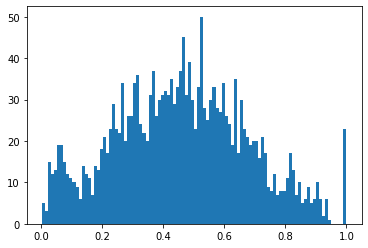

In [29]:
plt.hist([r['bleu-4'] for r in test_results], bins=100);
np.mean([r['bleu-4'] for r in test_results]),
np.median([r['bleu-4'] for r in test_results])

In [30]:
dataset.set_split('val')
batch_generator = generate_nmt_batches(dataset,
                                      batch_size=args.batch_size,
                                      device=args.device)
batch_dict = next(batch_generator)

model = model.eval().to(args.device)
sampler = NMTSampler(vectorizer, model)
sampler.apply_to_batch(batch_dict)

In [31]:
all_results = []
for i in range(args.batch_size):
    all_results.append(sampler.get_ith_item(i, False))

In [32]:
top_results = [x for x in all_results if x['bleu-4']>0.1]
len(top_results)

62

/home/malinroot/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


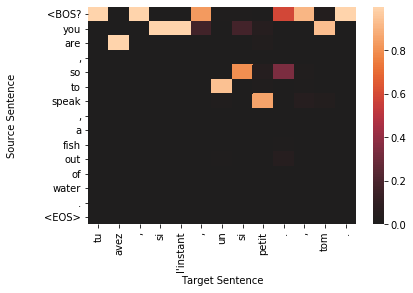

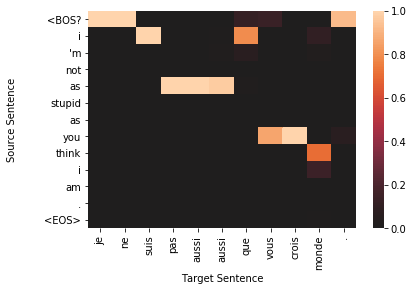

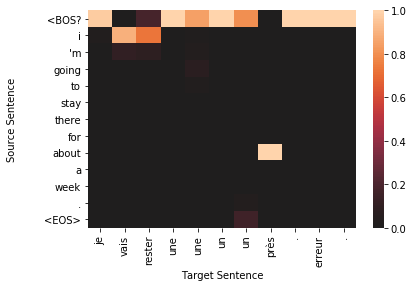

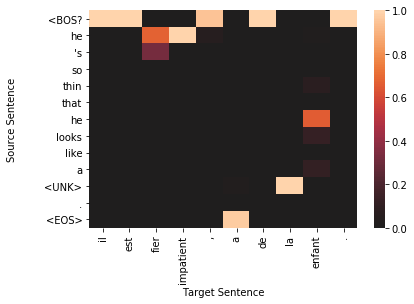

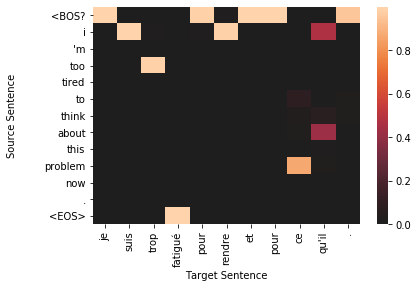

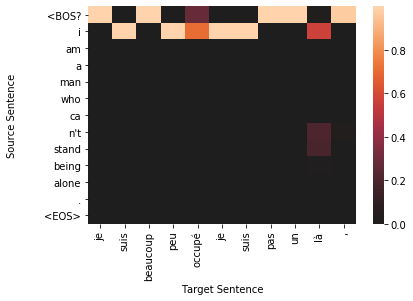

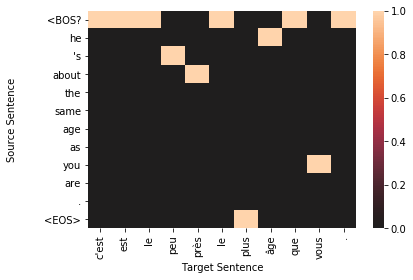

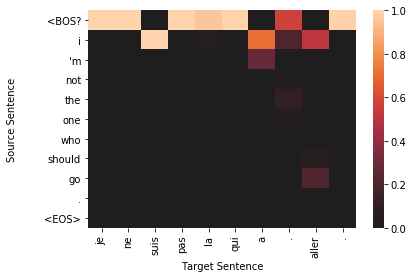

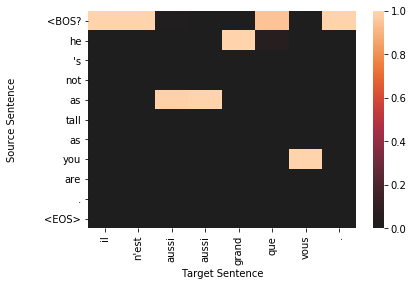

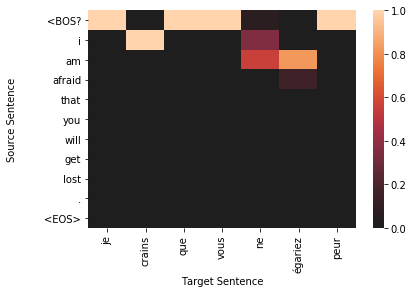

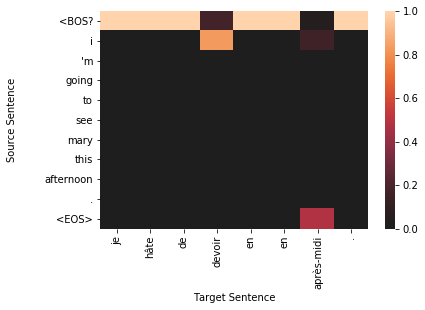

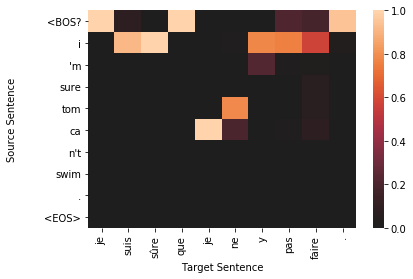

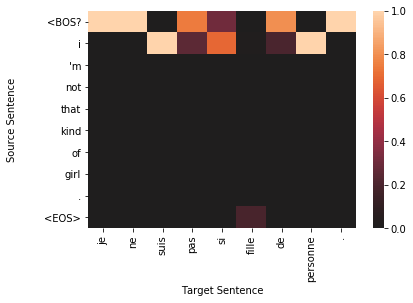

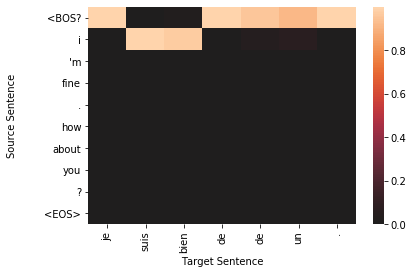

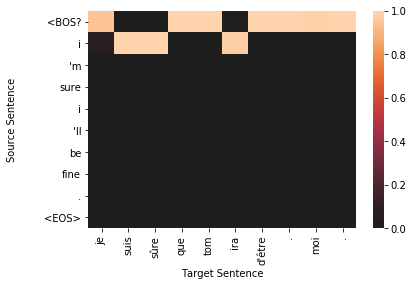

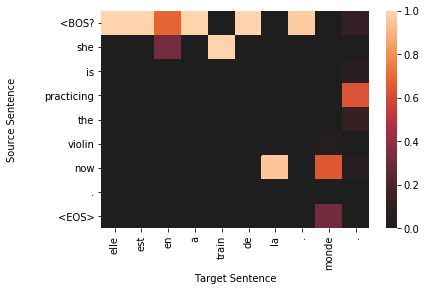

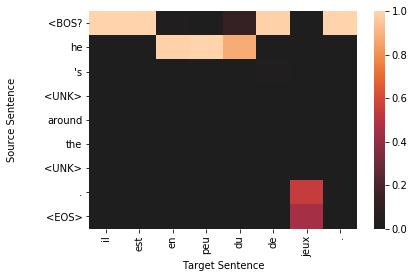

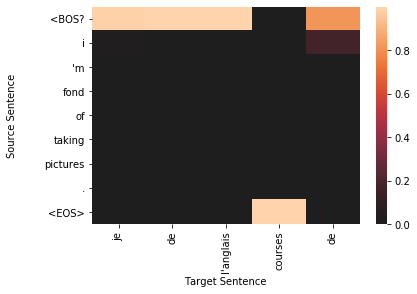

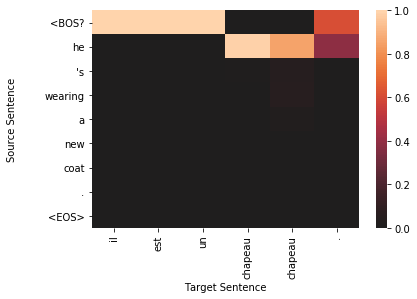

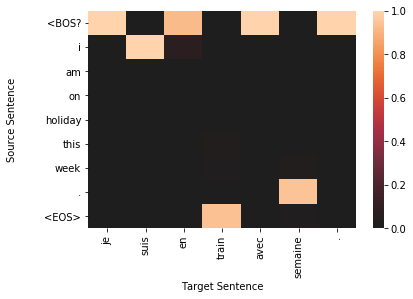

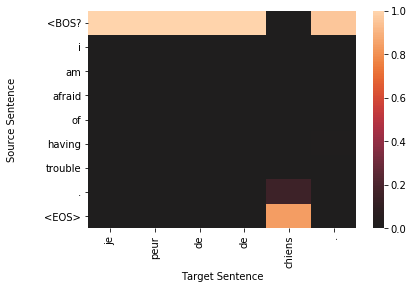

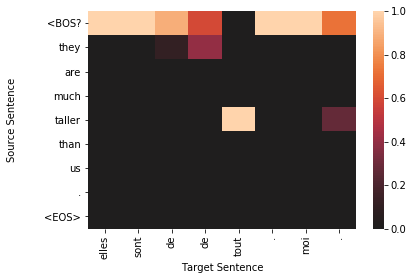

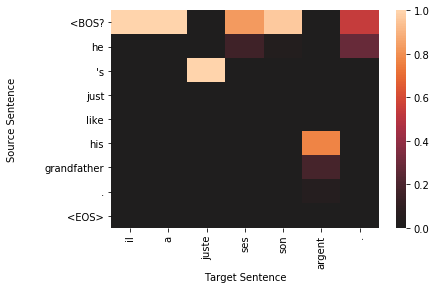

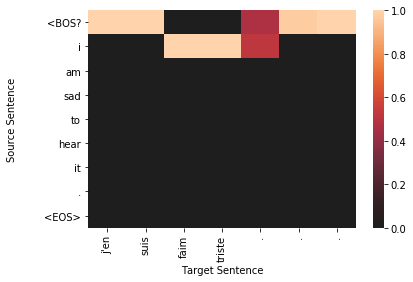

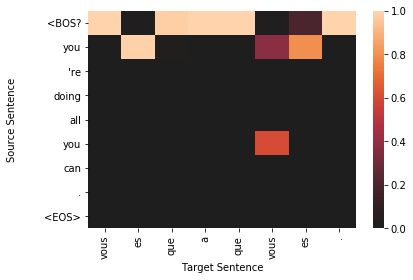

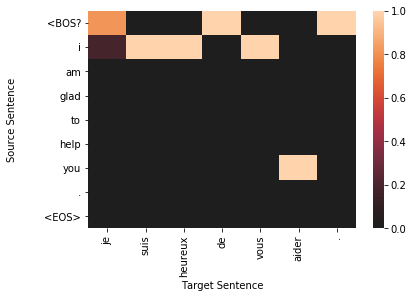

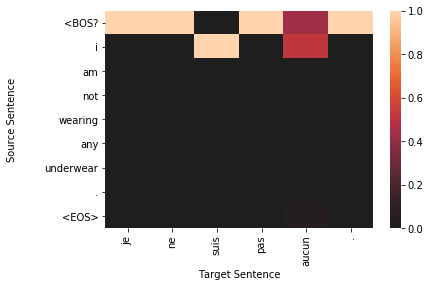

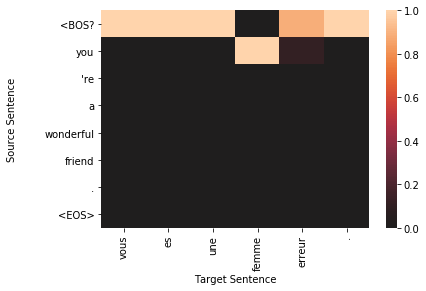

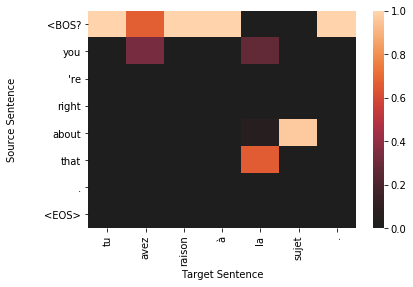

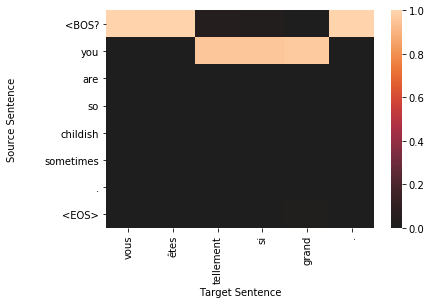

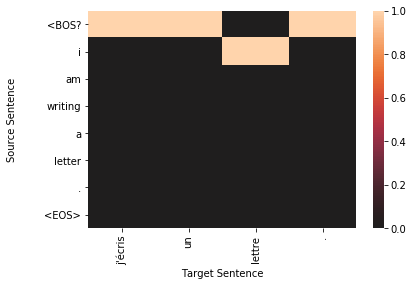

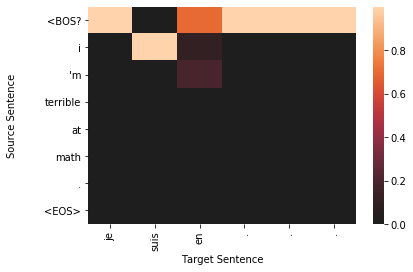

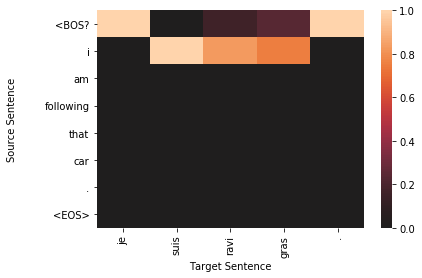

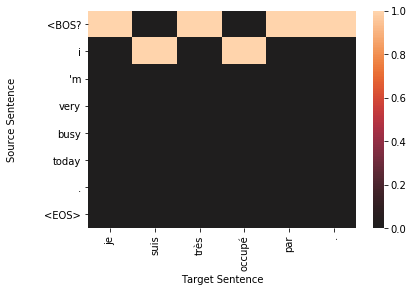

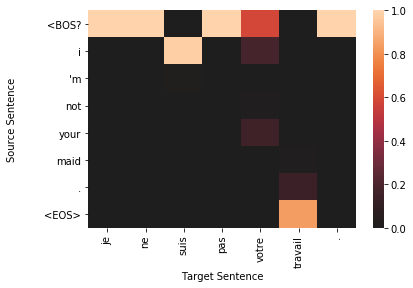

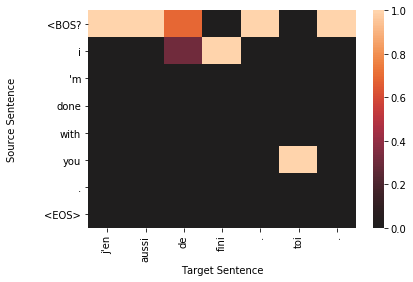

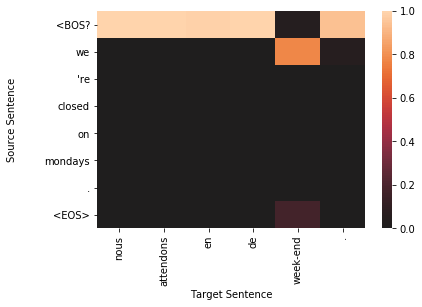

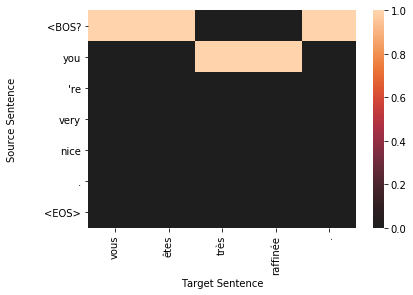

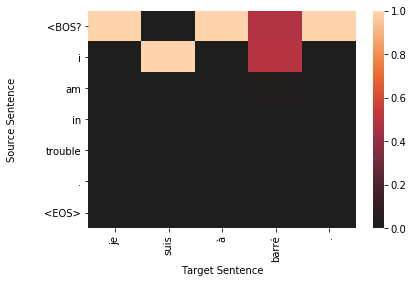

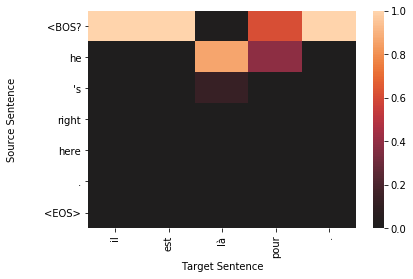

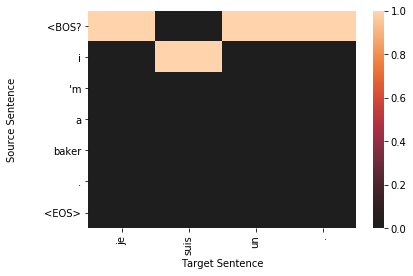

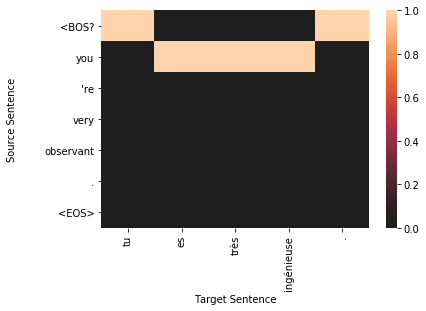

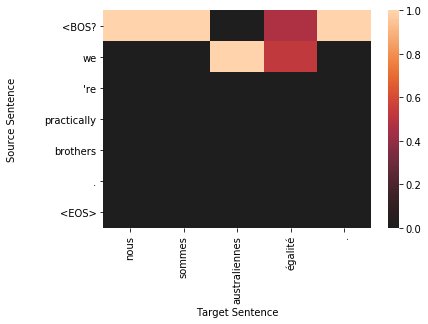

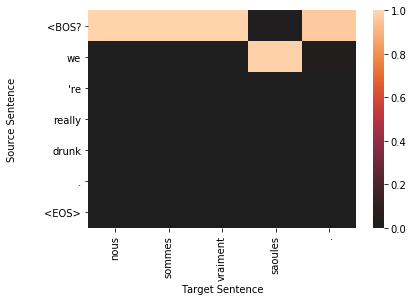

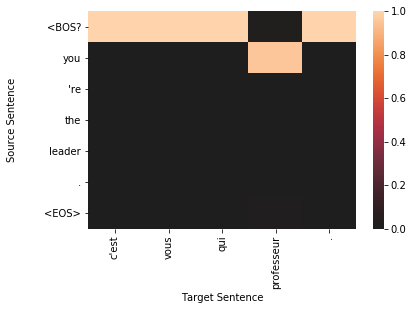

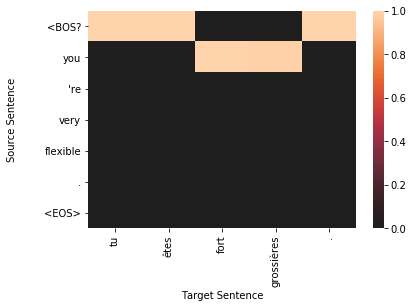

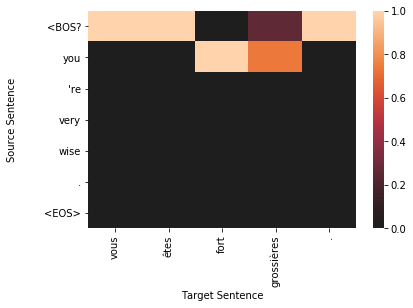

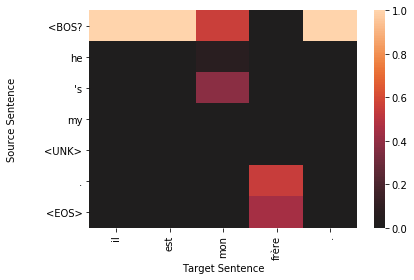

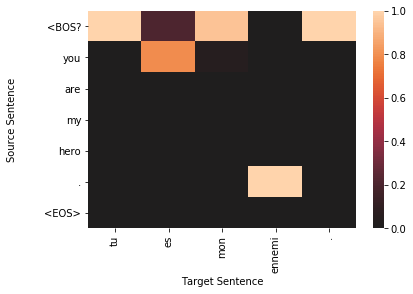

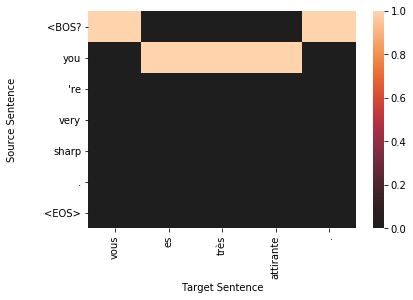

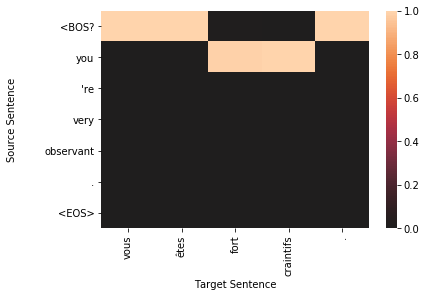

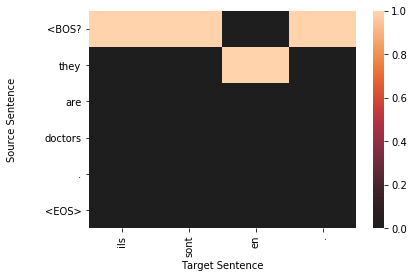

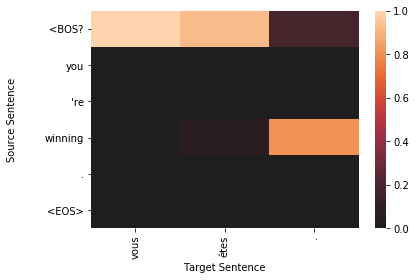

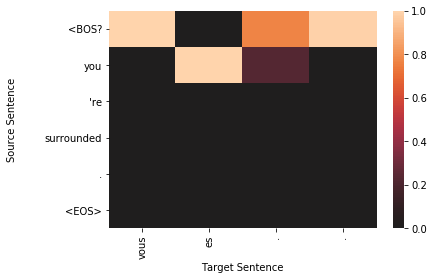

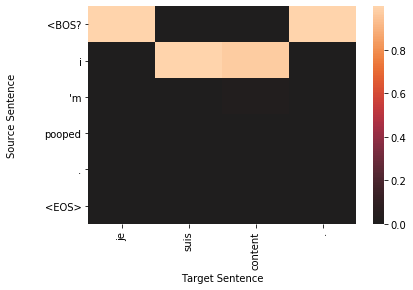

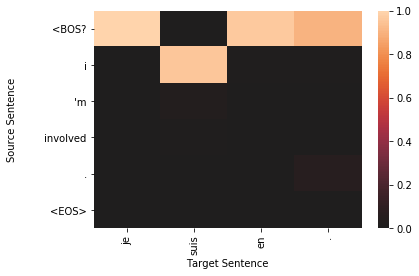

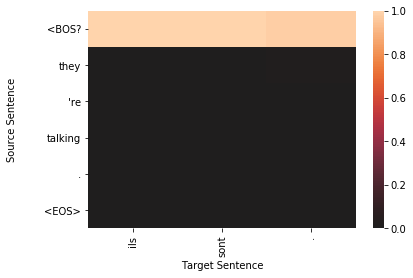

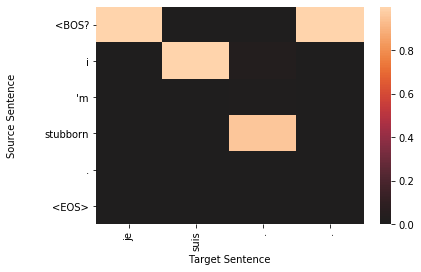

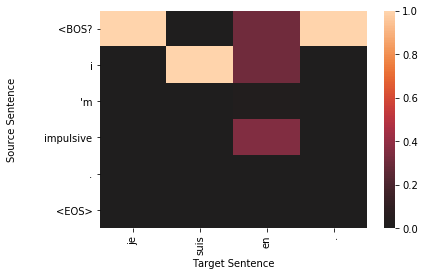

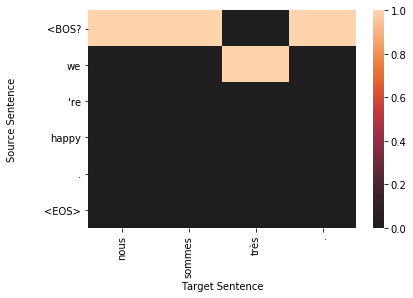

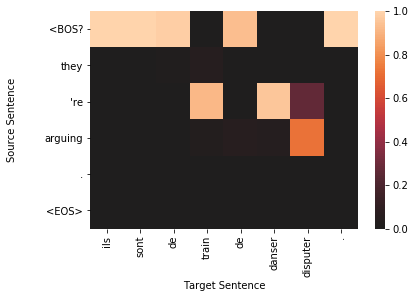

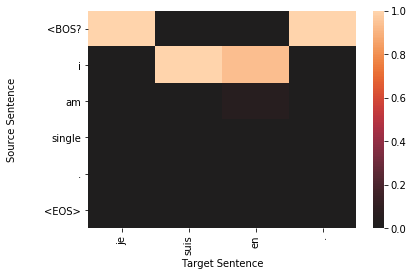

In [33]:
for sample in top_results:
    plt.figure()
    target_len = len(sample['sampled'])
    source_len = len(sample['source'])
    
    attention_matrix = sample['attention'][:target_len, :source_len+2].transpose()
    ax = sns.heatmap(attention_matrix, center=0.0)
    ylabs = ['<BOS?']+sample['source']+['<EOS>']
    
    ax.set_yticklabels(ylabs, rotation=0)
    ax.set_xticklabels(sample['sampled'], rotation=90)
    ax.set_xlabel('Target Sentence')
    ax.set_ylabel("Source Sentence\n\n")

In [34]:
def get_source_sentence(vectorizer, batch_dict, index):
    indices = batch_dict['x_source'][index].cpu().data.numpy()
    vocab = vectorizer.source_vocab
    return sentence_from_indices(indices, vocab)

def get_true_sentence(vectorizer, batch_dict, index):
    return sentence_from_indices(batch_dict['y_target'].cpu().data.numpy()[index], vectorizer.target_vocab)
    
def get_sampled_sentence(vectorizer, batch_dict, index):
    y_pred = model(x_source=batch_dict['x_source'], 
                   x_source_lengths=batch_dict['x_source_length'], 
                   target_sequence=batch_dict['x_target'])
    return sentence_from_indices(torch.max(y_pred, dim=2)[1].cpu().data.numpy()[index], vectorizer.target_vocab)

def get_all_sentences(vectorizer, batch_dict, index):
    return {"source": get_source_sentence(vectorizer, batch_dict, index), 
            "truth": get_true_sentence(vectorizer, batch_dict, index), 
            "sampled": get_sampled_sentence(vectorizer, batch_dict, index)}
    
def sentence_from_indices(indices, vocab, strict=True):
    ignore_indices = set([vocab.mask_index, vocab.begin_seq_index, vocab.end_seq_index])
    out = []
    for index in indices:
        if index == vocab.begin_seq_index and strict:
            continue
        elif index == vocab.end_seq_index and strict:
            return " ".join(out)
        else:
            out.append(vocab.lookup_index(index))
    return " ".join(out)

results = get_all_sentences(vectorizer, batch_dict, 1)
results

{'source': "i 'm not as stupid as you think i am .",
 'truth': 'je ne suis pas aussi bête que tu le penses .',
 'sampled': 'je ne suis pas aussi aussi que vous crois seul .'}

In [124]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

In [125]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None):
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
    def to_serializable(self):
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        return self._token_to_idx[token]

    def lookup_index(self, index):
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [126]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [127]:
class NMTVectorizer(object):
    def __init__(self, source_vocab, target_vocab, max_source_length, max_target_length):
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab
        
        self.max_source_length = max_source_length
        self.max_target_length = max_target_length
        

    def _vectorize(self, indices, vector_length=-1, mask_index=0):
        if vector_length < 0:
            vector_length = len(indices)
        
        vector = np.zeros(vector_length, dtype=np.int64)
        vector[:len(indices)] = indices
        vector[len(indices):] = mask_index

        return vector
    
    def _get_source_indices(self, text):
        indices = [self.source_vocab.begin_seq_index]
        indices.extend(self.source_vocab.lookup_token(token) for token in text.split(" "))
        indices.append(self.source_vocab.end_seq_index)
        return indices
    
    def _get_target_indices(self, text):
        indices = [self.target_vocab.lookup_token(token) for token in text.split(" ")]
        x_indices = [self.target_vocab.begin_seq_index] + indices
        y_indices = indices + [self.target_vocab.end_seq_index]
        return x_indices, y_indices
        
    def vectorize(self, source_text, target_text, use_dataset_max_lengths=True):
        source_vector_length = -1
        target_vector_length = -1
        
        if use_dataset_max_lengths:
            source_vector_length = self.max_source_length + 2
            target_vector_length = self.max_target_length + 1
            
        source_indices = self._get_source_indices(source_text)
        source_vector = self._vectorize(source_indices, 
                                        vector_length=source_vector_length, 
                                        mask_index=self.source_vocab.mask_index)
        
        target_x_indices, target_y_indices = self._get_target_indices(target_text)
        target_x_vector = self._vectorize(target_x_indices,
                                        vector_length=target_vector_length,
                                        mask_index=self.target_vocab.mask_index)
        target_y_vector = self._vectorize(target_y_indices,
                                        vector_length=target_vector_length,
                                        mask_index=self.target_vocab.mask_index)
        return {"source_vector": source_vector, 
                "target_x_vector": target_x_vector, 
                "target_y_vector": target_y_vector, 
                "source_length": len(source_indices)}
        
    @classmethod
    def from_dataframe(cls, bitext_df):
        source_vocab = SequenceVocabulary()
        target_vocab = SequenceVocabulary()
        
        max_source_length = 0
        max_target_length = 0

        for _, row in bitext_df.iterrows():
            source_tokens = row["source_language"].split(" ")
            if len(source_tokens) > max_source_length:
                max_source_length = len(source_tokens)
            for token in source_tokens:
                source_vocab.add_token(token)
            
            target_tokens = row["target_language"].split(" ")
            if len(target_tokens) > max_target_length:
                max_target_length = len(target_tokens)
            for token in target_tokens:
                target_vocab.add_token(token)
            
        return cls(source_vocab, target_vocab, max_source_length, max_target_length)

    @classmethod
    def from_serializable(cls, contents):
        source_vocab = SequenceVocabulary.from_serializable(contents["source_vocab"])
        target_vocab = SequenceVocabulary.from_serializable(contents["target_vocab"])
        
        return cls(source_vocab=source_vocab, 
                   target_vocab=target_vocab, 
                   max_source_length=contents["max_source_length"], 
                   max_target_length=contents["max_target_length"])

    def to_serializable(self):
        return {"source_vocab": self.source_vocab.to_serializable(), 
                "target_vocab": self.target_vocab.to_serializable(), 
                "max_source_length": self.max_source_length,
                "max_target_length": self.max_target_length}

In [128]:
class NMTDataset(Dataset):
    def __init__(self, text_df, vectorizer):
        self.text_df = text_df
        self._vectorizer = vectorizer

        self.train_df = self.text_df[self.text_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.text_df[self.text_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.text_df[self.text_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, dataset_csv):
        text_df = pd.read_csv(dataset_csv)
        train_subset = text_df[text_df.split=='train']
        return cls(text_df, NMTVectorizer.from_dataframe(train_subset))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, dataset_csv, vectorizer_filepath):
        text_df = pd.read_csv(dataset_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(text_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return NMTVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        row = self._target_df.iloc[index]

        vector_dict = self._vectorizer.vectorize(row.source_language, row.target_language)

        return {"x_source": vector_dict["source_vector"], 
                "x_target": vector_dict["target_x_vector"],
                "y_target": vector_dict["target_y_vector"], 
                "x_source_length": vector_dict["source_length"]}
        
    def get_num_batches(self, batch_size):
        return len(self) // batch_size

def generate_nmt_batches(dataset, batch_size, shuffle=True, 
                            drop_last=True, device="cpu"):
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        lengths = data_dict['x_source_length'].numpy()
        sorted_length_indices = lengths.argsort()[::-1].tolist()
        
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name][sorted_length_indices].to(device)
        yield out_data_dict

In [129]:
class NMTEncoder(nn.Module):
    def __init__(self, num_embeddings, embedding_size, rnn_hidden_size):
        super(NMTEncoder, self).__init__()
    
        self.source_embedding = nn.Embedding(num_embeddings, embedding_size, padding_idx=0)
        self.birnn = nn.GRU(embedding_size, rnn_hidden_size, bidirectional=True, batch_first=True)
    
    def forward(self, x_source, x_lengths):
        x_embedded = self.source_embedding(x_source)
        x_packed = pack_padded_sequence(x_embedded, x_lengths.detach().cpu().numpy(), 
                                        batch_first=True)
        
        x_birnn_out, x_birnn_h  = self.birnn(x_packed)
        x_birnn_h = x_birnn_h.permute(1, 0, 2)
        
        x_birnn_h = x_birnn_h.contiguous().view(x_birnn_h.size(0), -1)
        
        x_unpacked, _ = pad_packed_sequence(x_birnn_out, batch_first=True)
        
        return x_unpacked, x_birnn_h

def verbose_attention(encoder_state_vectors, query_vector):
    batch_size, num_vectors, vector_size = encoder_state_vectors.size()
    vector_scores = torch.sum(encoder_state_vectors * query_vector.view(batch_size, 1, vector_size), 
                              dim=2)
    vector_probabilities = F.softmax(vector_scores, dim=1)
    weighted_vectors = encoder_state_vectors * vector_probabilities.view(batch_size, num_vectors, 1)
    context_vectors = torch.sum(weighted_vectors, dim=1)
    return context_vectors, vector_probabilities, vector_scores

def terse_attention(encoder_state_vectors, query_vector):
    vector_scores = torch.matmul(encoder_state_vectors, query_vector.unsqueeze(dim=2)).squeeze()
    vector_probabilities = F.softmax(vector_scores, dim=-1)
    context_vectors = torch.matmul(encoder_state_vectors.transpose(-2, -1), 
                                   vector_probabilities.unsqueeze(dim=2)).squeeze()
    return context_vectors, vector_probabilities



class NMTDecoder(nn.Module):
    def __init__(self, num_embeddings, embedding_size, rnn_hidden_size, bos_index):
        super(NMTDecoder, self).__init__()
        self._rnn_hidden_size = rnn_hidden_size
        self.target_embedding = nn.Embedding(num_embeddings=num_embeddings, 
                                             embedding_dim=embedding_size, 
                                             padding_idx=0)
        self.gru_cell = nn.GRUCell(embedding_size + rnn_hidden_size, 
                                   rnn_hidden_size)
        self.hidden_map = nn.Linear(rnn_hidden_size, rnn_hidden_size)
        self.classifier = nn.Linear(rnn_hidden_size * 2, num_embeddings)
        self.bos_index = bos_index
        self._sampling_temperature = 3
    
    def _init_indices(self, batch_size):
        return torch.ones(batch_size, dtype=torch.int64) * self.bos_index
    
    def _init_context_vectors(self, batch_size):
        return torch.zeros(batch_size, self._rnn_hidden_size)
            
    def forward(self, encoder_state, initial_hidden_state, target_sequence, sample_probability=0.0):
        if target_sequence is None:
            sample_probability = 1.0
        else:
            target_sequence = target_sequence.permute(1, 0)
            output_sequence_size = target_sequence.size(0)
        
        h_t = self.hidden_map(initial_hidden_state)
        
        batch_size = encoder_state.size(0)
        context_vectors = self._init_context_vectors(batch_size)
        y_t_index = self._init_indices(batch_size)
        
        h_t = h_t.to(encoder_state.device)
        y_t_index = y_t_index.to(encoder_state.device)
        context_vectors = context_vectors.to(encoder_state.device)

        output_vectors = []
        self._cached_p_attn = []
        self._cached_ht = []
        self._cached_decoder_state = encoder_state.cpu().detach().numpy()
        
        for i in range(output_sequence_size):
            use_sample = np.random.random() < sample_probability
            if not use_sample:
                y_t_index = target_sequence[i]
                
            y_input_vector = self.target_embedding(y_t_index)
            rnn_input = torch.cat([y_input_vector, context_vectors], dim=1)
            
            h_t = self.gru_cell(rnn_input, h_t)
            self._cached_ht.append(h_t.cpu().detach().numpy())
            
            context_vectors, p_attn, _ = verbose_attention(encoder_state_vectors=encoder_state, 
                                                           query_vector=h_t)
            
            self._cached_p_attn.append(p_attn.cpu().detach().numpy())
            
            prediction_vector = torch.cat((context_vectors, h_t), dim=1)
            score_for_y_t_index = self.classifier(F.dropout(prediction_vector, 0.3))
            
            if use_sample:
                p_y_t_index = F.softmax(score_for_y_t_index * self._sampling_temperature, dim=1)
                y_t_index = torch.multinomial(p_y_t_index, 1).squeeze()
            
            output_vectors.append(score_for_y_t_index)
            
        output_vectors = torch.stack(output_vectors).permute(1, 0, 2)
        
        return output_vectors
    
    
class NMTModel(nn.Module):
    def __init__(self, source_vocab_size, source_embedding_size, 
                 target_vocab_size, target_embedding_size, encoding_size, 
                 target_bos_index):
        super(NMTModel, self).__init__()
        self.encoder = NMTEncoder(num_embeddings=source_vocab_size, 
                                  embedding_size=source_embedding_size,
                                  rnn_hidden_size=encoding_size)
        decoding_size = encoding_size * 2
        self.decoder = NMTDecoder(num_embeddings=target_vocab_size, 
                                  embedding_size=target_embedding_size, 
                                  rnn_hidden_size=decoding_size,
                                  bos_index=target_bos_index)
    
    def forward(self, x_source, x_source_lengths, target_sequence, sample_probability=0.0):
        encoder_state, final_hidden_states = self.encoder(x_source, x_source_lengths)
        decoded_states = self.decoder(encoder_state=encoder_state, 
                                      initial_hidden_state=final_hidden_states, 
                                      target_sequence=target_sequence, 
                                      sample_probability=sample_probability)
        return decoded_states

In [130]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):

    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
         
        if loss_t >= loss_tm1:
            train_state['early_stopping_step'] += 1
        else:
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            train_state['early_stopping_step'] = 0

        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def normalize_sizes(y_pred, y_true):
    if len(y_pred.size()) == 3:
        y_pred = y_pred.contiguous().view(-1, y_pred.size(2))
    if len(y_true.size()) == 2:
        y_true = y_true.contiguous().view(-1)
    return y_pred, y_true

def compute_accuracy(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)

    _, y_pred_indices = y_pred.max(dim=1)
    
    correct_indices = torch.eq(y_pred_indices, y_true).float()
    valid_indices = torch.ne(y_true, mask_index).float()
    
    n_correct = (correct_indices * valid_indices).sum().item()
    n_valid = valid_indices.sum().item()

    return n_correct / n_valid * 100

def sequence_loss(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)
    return F.cross_entropy(y_pred, y_true, ignore_index=mask_index)

In [131]:
args = Namespace(
    dataset_csv='data/n/simplest_eng_fra.csv',
    vectorizer_file='vectorizer.json',
    model_state_file='model.pth',
    save_dir='model_storage/c/nmt_luong_sampling',
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
    cuda=True,
    seed=1337,
    learning_rate=5e-4,
    batch_size=32,
    num_epochs=100,
    early_stopping_criteria=5,
    source_embedding_size=24,
    target_embedding_size=24,
    encoding_size=32,
    catch_keyboard_interrupt=True
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                       args.vectorizer_file)
    args.model_state_file = os.path.join(args.save_dir,
                                        args.model_state_file)
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
if not torch.cuda.is_available():
    args.cuda = False
    
args.device = torch.device('cuda' if args.cuda else 'cpu')

print("Using CUDA: {}".format(args.cuda))

set_seed_everywhere(args.seed, args.cuda)

handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/c/nmt_luong_sampling/vectorizer.json
	model_storage/c/nmt_luong_sampling/model.pth
Using CUDA: False


In [132]:
if args.reload_from_files and os.path.exists(args.vectorizer_file):
    dataset = NMTDataset.load_dataset_and_load_vectorizer(args.dataset_csv,
                                                          args.vectorizer_file)
else:
    dataset = NMTDataset.load_dataset_and_make_vectorizer(args.dataset_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

In [133]:
model = NMTModel(source_vocab_size=len(vectorizer.source_vocab),
                source_embedding_size=args.source_embedding_size,
                target_vocab_size=len(vectorizer.target_vocab),
                target_embedding_size=args.target_embedding_size,
                encoding_size=args.encoding_size,
                target_bos_index=vectorizer.target_vocab.begin_seq_index)

if args.reload_from_files and os.path.exists(args.model_state_file):
    model.load_state_dict(torch.load(args.model_state_file))
    print("Reloaded model")
else:
    print("New model")

New model


In [134]:
model = model.to(args.device)

optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
mask_index = vectorizer.target_vocab.mask_index
train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        sample_probability = (20 + epoch_index) / args.num_epochs
        
        train_state['epoch_index'] = epoch_index

        dataset.set_split('train')
        batch_generator = generate_nmt_batches(dataset, 
                                               batch_size=args.batch_size, 
                                               device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        model.train()
        
        for batch_index, batch_dict in enumerate(batch_generator):

            optimizer.zero_grad()

            y_pred = model(batch_dict['x_source'], 
                           batch_dict['x_source_length'], 
                           batch_dict['x_target'],
                           sample_probability=sample_probability)

            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            loss.backward()

            optimizer.step()

            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)


        dataset.set_split('val')
        batch_generator = generate_nmt_batches(dataset, 
                                               batch_size=args.batch_size, 
                                               device=args.device)
        running_loss = 0.
        running_acc = 0.
        model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            y_pred = model(batch_dict['x_source'], 
                           batch_dict['x_source_length'], 
                           batch_dict['x_target'],
                           sample_probability=sample_probability)


            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=model, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break
        
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.set_postfix(best_val=train_state['early_stopping_best_val'])
        epoch_bar.update()
        
except KeyboardInterrupt:
    print("Exiting loop")

/home/malinroot/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


/home/malinroot/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/malinroot/.local/lib/python3.7/site-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Exiting loop


In [135]:
from nltk.translate import bleu_score
import seaborn as sns
import matplotlib.pyplot as plt

chencherry = bleu_score.SmoothingFunction()

In [136]:
def sentence_from_indices(indices, vocab, strict=True, return_string=True):
    ignore_indices = set([vocab.mask_index, vocab.begin_seq_index, vocab.end_seq_index])
    out = []
    for index in indices:
        if index == vocab.begin_seq_index and strict:
            continue
        elif index == vocab.end_seq_index and strict:
            break
        else:
            out.append(vocab.lookup_index(index))
    if return_string:
        return " ".join(out)
    else:
        return out
    
class NMTSampler:
    def __init__(self, vectorizer, model):
        self.vectorizer = vectorizer
        self.model = model
    
    def apply_to_batch(self, batch_dict):
        self._last_batch = batch_dict
        y_pred = self.model(x_source=batch_dict['x_source'],
                           x_source_lengths=batch_dict['x_source_length'],
                           target_sequence=batch_dict['x_target'])
        self._last_batch['y_pred'] = y_pred
        attention_batched = np.stack(self.model.decoder._cached_p_attn).transpose(1, 0, 2)
        self._last_batch['attention'] = attention_batched
    
    def _get_source_sentence(self, index, return_string=True):
        indices = self._last_batch['x_source'][index].cpu().detach().numpy()
        vocab = self.vectorizer.source_vocab
        return sentence_from_indices(indices, vocab, return_string=return_string)
    
    def _get_reference_sentence(self, index, return_string=True):
        indices = self._last_batch['y_target'][index].cpu().detach().numpy()
        vocab = self.vectorizer.target_vocab
        return sentence_from_indices(indices, vocab, return_string=return_string)
    
    def _get_sampled_sentence(self, index, return_string=True):
        _, all_indices = torch.max(self._last_batch['y_pred'], dim=2)
        sentence_indices = all_indices[index].cpu().detach().numpy()
        vocab = self.vectorizer.target_vocab
        return sentence_from_indices(sentence_indices, vocab, return_string=return_string)
    
    def get_ith_item(self, index, return_string=True):
        output = {
            'source': self._get_source_sentence(index, return_string=return_string),
            'reference': self._get_reference_sentence(index, return_string=return_string),
            'sampled': self._get_sampled_sentence(index, return_string=return_string),
            'attention': self._last_batch['attention'][index]
        
        }
        reference = output['reference']
        hypothesis = output['sampled']
        if not return_string:
            reference = " ".join(reference)
            hypothesis = " ".join(hypothesis)
        output['bleu-4'] = bleu_score.sentence_bleu(references=[reference],
                                                   hypothesis=hypothesis,
                                                   smoothing_function=chencherry.method1)
        return output

In [137]:
model = model.eval().to(args.device)
sampler = NMTSampler(vectorizer, model)
dataset.set_split('test')
batch_generator = generate_nmt_batches(dataset,
                                      batch_size=args.batch_size,
                                      device=args.device)
test_results = []
for batch_dict in batch_generator:
    sampler.apply_to_batch(batch_dict)
    for i in range(args.batch_size):
        test_results.append(sampler.get_ith_item(i, False))

0.0372025172275601

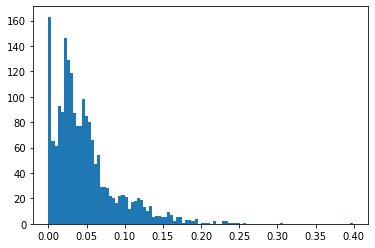

In [138]:
plt.hist([r['bleu-4'] for r in test_results], bins=100);
np.mean([r['bleu-4'] for r in test_results]),
np.median([r['bleu-4'] for r in test_results])

In [139]:
dataset.set_split('val')
batch_generator = generate_nmt_batches(dataset,
                                      batch_size=args.batch_size,
                                      device=args.device)
batch_dict = next(batch_generator)
model = model.eval().to(args.device)
sampler = NMTSampler(vectorizer, model)
sampler.apply_to_batch(batch_dict)

In [140]:
all_results = []
for i  in range(args.batch_size):
    all_results.append(sampler.get_ith_item(i, False))

In [141]:
top_results = [x for x in all_results if x['bleu-4']>0.5]
len(top_results)

0

In [142]:
for sample in top_results:
    plt.figure()
    target_len = len(sample['sampled'])
    source_len = len(sample['source'])
    
    attention_matrix = sample['attention'][:target_len, :source_len+2].transpose()
    ax = sns.heatmap(attention_matrix, center=0.0)
    ylabs = ["<BOS>"]+sample['source']+['<EOS>']
    ax.set_yticklabels(ylabs, rotation=0)
    ax.set_xticklabels(sample['sampled'], rotation=90)
    ax.set_xlabel("Target Sentence")
    ax.set_ylabel('Source Sentence\n\n')

In [89]:
def get_source_sentence(vectorizer, batch_dict, index):
    indices = batch_dict['x_source'][index].cpu().data.numpy()
    vocab = vectorizer.source_vocab
    return sentence_from_indices(indices, vocab)

def get_true_sentence(vectorizer, batch_dict, index):
    return sentence_from_indices(batch_dict['y_target'].cpu().data.numpy()[index], vectorizer.target_vocab)
    
def get_sampled_sentence(vectorizer, batch_dict, index):
    y_pred = model(x_source=batch_dict['x_source'], 
                   x_source_lengths=batch_dict['x_source_length'], 
                   target_sequence=batch_dict['x_target'], 
                   sample_probability=1.0)
    return sentence_from_indices(torch.max(y_pred, dim=2)[1].cpu().data.numpy()[index], vectorizer.target_vocab)

def get_all_sentences(vectorizer, batch_dict, index):
    return {"source": get_source_sentence(vectorizer, batch_dict, index), 
            "truth": get_true_sentence(vectorizer, batch_dict, index), 
            "sampled": get_sampled_sentence(vectorizer, batch_dict, index)}
    
def sentence_from_indices(indices, vocab, strict=True):
    ignore_indices = set([vocab.mask_index, vocab.begin_seq_index, vocab.end_seq_index])
    out = []
    for index in indices:
        if index == vocab.begin_seq_index and strict:
            continue
        elif index == vocab.end_seq_index and strict:
            return " ".join(out)
        else:
            out.append(vocab.lookup_index(index))
    return " ".join(out)

results = get_all_sentences(vectorizer, batch_dict, 1)
results


{'source': "i 'm not going to let anything happen to you .",
 'truth': 'je ne vais rien laisser vous arriver .',
 'sampled': "compares l'adorent disposons irremplaçable d'apprendre plaît l'homme pigeons connais-tu tard t'es compares compares soin nobles arrivée quatre-vingt-dix l'ami bienveillants sueur tricote analysez voies minute 100"}

In [90]:
from argparse import Namespace
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd

In [92]:
args = Namespace(
    source_data_path='data/n/eng-fra.txt',
    output_data_path='data/n/simplest_eng_fra.csv',
    perc_train=0.7,
    perc_val=0.15,
    perc_test=0.15,
    seed=1337
)

assert args.perc_test > 0 and (args.perc_test + args.perc_val + args.perc_train == 1.0)

In [93]:
with open(args.source_data_path) as fp:
    lines = fp.readlines()

lines = [line.replace("\n", "").lower().split("\t") for line in lines]

In [94]:
data = []
for english_sentence, french_sentence in lines:
    data.append({
        'english_tokens': word_tokenize(english_sentence, language='english'),
        'french_tokens': word_tokenize(french_sentence, language='french')
    })

In [95]:
filter_phrases = (
    ("i", "am"), ("i", "'m"),
    ("he", "is"), ("he", "'s"),
    ("she", "is"), ("she", "'s"),
    ('you', 'are'), ('you', "'re"),
    ("we", 'are'), ('we', "'re"),
    ("they", "are"), ("they", "'re")
)

In [96]:
data_subset = {phrase: [] for phrase in filter_phrases}
for datum in data:
    key = tuple(datum['english_tokens'][:2])
    if key in data_subset:
        data_subset[key].append(datum)

In [98]:
counts = {k: len(v) for k, v in data_subset.items()}
counts, sum(counts.values())

({('i', 'am'): 805,
  ('i', "'m"): 4760,
  ('he', 'is'): 1069,
  ('he', "'s"): 787,
  ('she', 'is'): 504,
  ('she', "'s"): 316,
  ('you', 'are'): 449,
  ('you', "'re"): 2474,
  ('we', 'are'): 181,
  ('we', "'re"): 1053,
  ('they', 'are'): 194,
  ('they', "'re"): 470},
 13062)

In [100]:
np.random.seed(args.seed)
dataset_stage3 = []
for phrase, datum_list in sorted(data_subset.items()):
    np.random.shuffle(datum_list)
    n_train = int(len(datum_list) * args.perc_train)
    n_val = int(len(datum_list) * args.perc_val)
    for datum in datum_list[:n_train]:
        datum['split'] = 'train'
    for datum in datum_list[n_train:n_train+n_val]:
        datum['split'] = 'val'
    for datum in datum_list[n_train+n_val:]:
        datum['split'] = 'test'
    
    dataset_stage3.extend(datum_list)

In [101]:
for datum in dataset_stage3:
    datum['source_language'] = " ".join(datum.pop('english_tokens'))
    datum['target_language'] = " ".join(datum.pop('french_tokens'))

In [105]:
nmt_df = pd.DataFrame(dataset_stage3)

In [106]:
nmt_df.head()

,split,source_language,target_language
0,train,he 's eager to speak to you .,il a hâte de vous parler .
1,train,he 's never been abroad in his life .,il n ' a jamais été à l'étranger de toute sa v...
2,train,he 's coming closer .,il se rapproche .
3,train,he 's after me .,il est après moi .
4,train,he 's an ex-con .,c'est un ancien détenu .


In [108]:
nmt_df.to_csv(args.output_data_path)

In [143]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [144]:
def describe(x):
    print("Type: {}".format(x.type()))
    print("Shape/size: {}".format(x.shape))
    print("Values: \n{}".format(x))

In [146]:
abcd_padded = torch.tensor([1, 2, 3, 4], dtype=torch.float32)
efg_padded = torch.tensor([5, 6, 7, 0], dtype=torch.float32)
h_padded = torch.tensor([8, 0, 0, 0], dtype=torch.float32)

padded_tensor = torch.stack([abcd_padded, efg_padded, h_padded])

describe(padded_tensor)

Type: torch.FloatTensor
Shape/size: torch.Size([3, 4])
Values: 
tensor([[1., 2., 3., 4.],
        [5., 6., 7., 0.],
        [8., 0., 0., 0.]])


In [147]:
lengths = [4, 3, 1]
packed_tensor = pack_padded_sequence(padded_tensor, lengths, batch_first=True)

packed_tensor

PackedSequence(data=tensor([1., 5., 8., 2., 6., 3., 7., 4.]), batch_sizes=tensor([3, 2, 2, 1]), sorted_indices=None, unsorted_indices=None)

In [148]:
unpacked_tensor, unpacked_lengths = pad_packed_sequence(packed_tensor, batch_first=True)
describe(unpacked_tensor)
describe(unpacked_lengths)

Type: torch.FloatTensor
Shape/size: torch.Size([3, 4])
Values: 
tensor([[1., 2., 3., 4.],
        [5., 6., 7., 0.],
        [8., 0., 0., 0.]])
Type: torch.LongTensor
Shape/size: torch.Size([3])
Values: 
tensor([4, 3, 1])
